# SHAP

#### Import the libraries

In [1]:
import xgboost
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load JS visualization code to notebook
shap.initjs()

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#### Read the data

In [4]:
# read the data
df = pd.read_csv('../data/total_dry_no_info.csv', index_col=0, low_memory=False)

#### Normalize the dataset

In [5]:
# delete unnamed column
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
# convert all columns of DataFrame
df = df.dropna()
# find the objects columns
cols = df.columns[df.dtypes.eq('object')]
# convert to numeric these columns
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

In [6]:
df.shape

(601076, 47)

In [7]:
df = df[df['language_Scala'] == 1]
#df = df[df['phases_project'] == 1]

In [8]:
# C - normal (amortization)
# Java - has_wiki and size
# Python - normal (amortization)
# Ruby - fork
# PHP - normal probably
# Scala - has wiki, fork

In [9]:
df.drop('network_count', axis=1, inplace=True)
df.drop('forks', axis=1, inplace=True)

#df.drop('fork', axis=1, inplace=True)
df.drop('size', axis=1, inplace=True)
#df.drop('watchers', axis=1, inplace=True)
df.drop('has_wiki', axis=1, inplace=True)
#df.drop('open_issues', axis=1, inplace=True)

In [10]:
# dropping the columns that we do not need
#df.drop('language_C', axis=1, inplace=True)
#df.drop('language_C#', axis=1, inplace=True)
#df.drop('language_C++', axis=1, inplace=True)
#df.drop('language_CSS', axis=1, inplace=True)
#df.drop('language_CoffeeScript', axis=1, inplace=True)
#df.drop('language_Go', axis=1, inplace=True)
#df.drop('language_Java', axis=1, inplace=True)
#df.drop('language_JavaScript', axis=1, inplace=True)
#df.drop('language_PHP', axis=1, inplace=True)
#df.drop('language_Perl', axis=1, inplace=True)
#df.drop('language_Python', axis=1, inplace=True)
#df.drop('language_R', axis=1, inplace=True)
#df.drop('language_Ruby', axis=1, inplace=True)
#df.drop('language_Scala', axis=1, inplace=True)
#df.drop('language_Shell', axis=1, inplace=True)
#df.drop('language_TypeScript', axis=1, inplace=True)
#df.drop('network_count', axis=1, inplace=True)
#df.drop('forks', axis=1, inplace=True)

In [11]:
# separating X and y
cols = [col for col in df.columns if col not in ['mean_commits']]
X = df[cols]
y = df['mean_commits']

In [12]:
# train XGBoost model
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

In [13]:
# explain the model's predictions using SHAP values.
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [14]:
# we can use shap.approximate_interactions to guess which features
# may interact with age
#inds = shap.approximate_interactions("phases_project", shap_values, X)

# make plots colored by each of the top three possible interacting features
#for i in range(5):
#    shap.dependence_plot("phases_project", shap_values, X, interaction_index=inds[i])

#### Summary plot

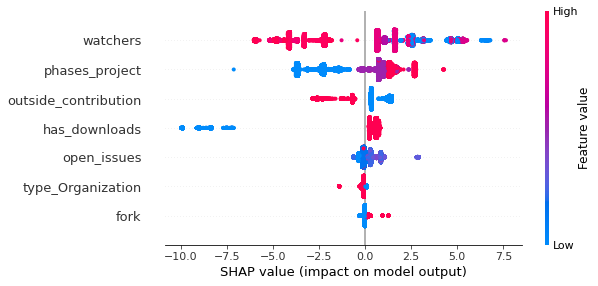

In [15]:
shap.summary_plot(shap_values, X, max_display=7,show=False)
plt.savefig('../reports/java.eps',dpi=800,bbox_inches='tight')

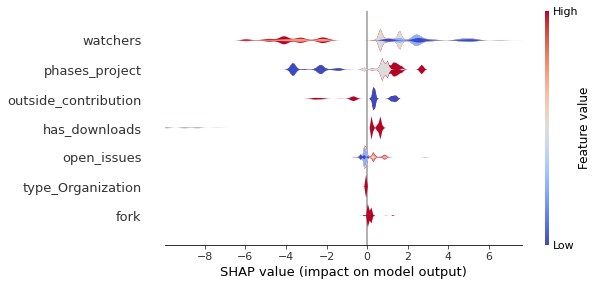

In [16]:
shap.summary_plot(
    shap_values,
    X,
    max_display=7,
    layered_violin_max_num_bins=5,
    plot_type='layered_violin'
)

In [ ]:
shap.decision_plot(
    explainer.expected_value,
    shap_values,
    X,
    link='identity',
    feature_order='hclust',
    feature_display_range=slice(None, -200, -1),
    #show=False,
    ignore_warnings=True
)

#### Bar Plot

In [55]:
def amortizacao(value):
    return value + 0.5

In [56]:
shap_v = pd.DataFrame(shap_values)
feature_list = X.columns
shap_v.columns = feature_list
df_v = X.copy()#.reset_index().drop('index',axis=1)
    
# Determine the correlation in order to plot with different colors
corr_list = list()
for i in feature_list:
    b = np.corrcoef(shap_v[i],df_v[i])[1][0]
    corr_list.append(b)

/home/geanderson/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/geanderson/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [57]:
corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
# Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
corr_df.columns  = ['Feature','Corr']
corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')

In [58]:
# Plot it
shap_abs = np.abs(shap_v)
k=pd.DataFrame(shap_abs.mean()).reset_index()
k.columns = ['Feature','SHAP_abs']
k2 = k.merge(corr_df,left_on = 'Feature',right_on='Feature',how='inner')
k2 = k2.sort_values(by='SHAP_abs',ascending = True)
k3 = k2.tail(7)
colorlist = k3['Sign']
k3['SHAP_abs'] = k3['SHAP_abs'].apply(amortizacao)

/home/geanderson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [59]:
k3

,Feature,SHAP_abs,Corr,Sign
33,total_files,0.568968,-0.445892,blue
8,has_downloads,0.740513,-0.710877,blue
10,open_issues,0.772117,0.514380,red
37,tests_included,0.807322,0.854312,red
7,has_issues,1.499043,-0.734382,blue
11,watchers,3.676312,-0.609041,blue
6,size,10.118387,0.988604,red


In [60]:
k3.at[6, 'SHAP_abs'] = 6.118987

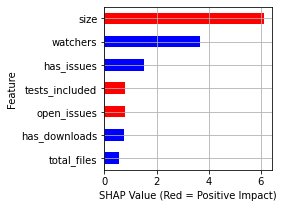

In [69]:
ax = k3.plot.barh(x='Feature',y='SHAP_abs',color = colorlist, figsize=(3,3),legend=False)
ax.set_xlabel("SHAP Value (Red = Positive Impact)")
ax.grid()
plt.savefig('../reports/python_phase_one.png',dpi=100,bbox_inches='tight')

#### SNS Plot

In [22]:
k4 = k3.sort_values(by=['SHAP_abs'], ascending=False)
colorlist = k4['Sign']

In [23]:
k4

,Feature,SHAP_abs,Corr,Sign
9,has_wiki,4.074996,-0.984299,blue
31,type_Organization,1.136008,0.729896,red
11,watchers,0.956382,0.077115,red
6,size,0.774969,-0.056962,blue
8,has_downloads,0.766442,0.994865,red
10,open_issues,0.744064,-0.264964,blue
5,fork,0.674782,-0.505209,blue


In [24]:
#k4.at[6, 'SHAP_abs'] = 6.118208

In [25]:
#import seaborn as sns

#sns.set(rc={'figure.figsize':(3,3)})
#sns.set(style="whitegrid")

In [26]:
#ax = sns.barplot(data=k4, x='SHAP_abs', y='Feature', palette=colorlist,
                 #orient='h')

#ax.set_xlabel("SHAP Value (Red = Positive Impact)")
#plt.savefig('../reports/php_phase_one.png',bbox_inches='tight')

IndentationError: unexpected indent (<ipython-input-26-90dec2e02da0>, line 2)

#### That's all folks!!!